In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR


In [ ]:
train_data_dir = 'category_train_og'
categories = os.listdir(train_data_dir)
print(categories)

['Jeans', 'Shoes', 'Tops']


In [7]:
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


3
{'Jeans': 0, 'Shoes': 1, 'Tops': 2}
{0: 'Jeans', 1: 'Shoes', 2: 'Tops'}


In [8]:
def random_pick() -> tuple[np.ndarray, int]:
    category = random.choice(categories)
    img_fnames = os.listdir(f'{train_data_dir}/{category}')
    img_path = f'{train_data_dir}/{category}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = category_to_label[category]
    return img, label

image_shape=(800, 800, 3)


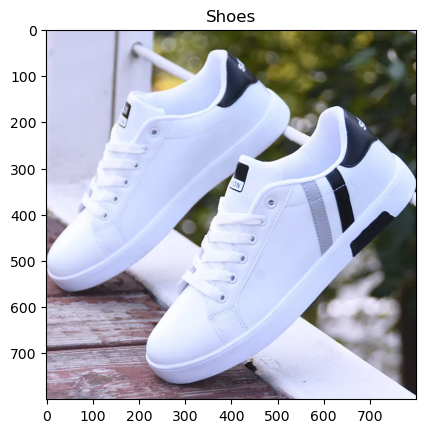

In [9]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_category[label])
plt.show()

In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [11]:
# create a class to preload the images and transform for pytorch processing

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((224, 224)), # resize it to a square of 224x224
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('RGB') # open image and convert to RGB
        t_img = self.transform(img) # transform the image defined above
        return t_img

In [14]:
class ImageDataset(Dataset):

    train_data_dir = 'category_train_og'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [15]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


In [16]:
dataset[0][1].shape

torch.Size([3, 224, 224])

In [17]:
val_ratio = 0.2
test_size = 30

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [18]:
len(dataset)

231

In [19]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 155, val: 46, test: 30


In [20]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [21]:
import torch.nn as nn

In [22]:
class CategoryClassifier(nn.Module):
    def __init__(self):
        super(CategoryClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.25),
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.output = nn.Sequential(
            nn.Linear(256, num_labels)
        )


        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)

        return x

In [23]:
model = CategoryClassifier().to(device)

In [24]:
from torchsummary import summary

summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [28]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [29]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [31]:
epochs = 100

#scheduler = StepLR(optimizer, step_size = 150, gamma = 0.1) # decrease epoch by 0.1 every 50 steps

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)

    #scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=1, train_loss=8.414, val_loss=17.375, train_accuracy=0.606, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=2, train_loss=3.184, val_loss=14.920, train_accuracy=0.619, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


epoch=3, train_loss=2.233, val_loss=13.756, train_accuracy=0.632, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


epoch=4, train_loss=3.985, val_loss=13.552, train_accuracy=0.652, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=5, train_loss=3.599, val_loss=11.551, train_accuracy=0.645, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


epoch=6, train_loss=2.293, val_loss=10.605, train_accuracy=0.626, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


epoch=7, train_loss=2.365, val_loss=10.580, train_accuracy=0.600, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


epoch=8, train_loss=6.804, val_loss=10.567, train_accuracy=0.632, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


epoch=9, train_loss=2.689, val_loss=9.199, train_accuracy=0.594, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=10, train_loss=1.457, val_loss=8.719, train_accuracy=0.600, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


epoch=11, train_loss=2.028, val_loss=8.466, train_accuracy=0.619, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


epoch=12, train_loss=1.685, val_loss=7.941, train_accuracy=0.639, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=13, train_loss=1.699, val_loss=8.227, train_accuracy=0.606, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=14, train_loss=1.868, val_loss=8.207, train_accuracy=0.619, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=15, train_loss=2.685, val_loss=8.465, train_accuracy=0.639, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=16, train_loss=1.580, val_loss=8.350, train_accuracy=0.677, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


epoch=17, train_loss=1.792, val_loss=8.784, train_accuracy=0.658, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=18, train_loss=1.583, val_loss=8.425, train_accuracy=0.632, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


epoch=19, train_loss=5.109, val_loss=8.230, train_accuracy=0.677, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


epoch=20, train_loss=2.934, val_loss=8.986, train_accuracy=0.677, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


epoch=21, train_loss=1.726, val_loss=8.451, train_accuracy=0.619, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=22, train_loss=1.792, val_loss=8.617, train_accuracy=0.652, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


epoch=23, train_loss=3.983, val_loss=8.669, train_accuracy=0.645, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


epoch=24, train_loss=1.399, val_loss=8.440, train_accuracy=0.639, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


epoch=25, train_loss=1.572, val_loss=7.764, train_accuracy=0.626, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


epoch=26, train_loss=1.308, val_loss=7.527, train_accuracy=0.652, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


epoch=27, train_loss=3.612, val_loss=7.412, train_accuracy=0.639, val_accuracy=0.696


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=28, train_loss=1.165, val_loss=7.050, train_accuracy=0.671, val_accuracy=0.543


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=29, train_loss=1.297, val_loss=7.519, train_accuracy=0.645, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


epoch=30, train_loss=1.014, val_loss=7.618, train_accuracy=0.658, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


epoch=31, train_loss=2.033, val_loss=7.072, train_accuracy=0.716, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


epoch=32, train_loss=1.088, val_loss=6.771, train_accuracy=0.613, val_accuracy=0.543


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=33, train_loss=1.581, val_loss=6.619, train_accuracy=0.658, val_accuracy=0.587


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


epoch=34, train_loss=1.148, val_loss=5.915, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch=35, train_loss=1.124, val_loss=5.864, train_accuracy=0.684, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=36, train_loss=1.467, val_loss=5.744, train_accuracy=0.645, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


epoch=37, train_loss=3.197, val_loss=5.955, train_accuracy=0.632, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


epoch=38, train_loss=1.459, val_loss=5.578, train_accuracy=0.716, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=39, train_loss=1.959, val_loss=5.364, train_accuracy=0.690, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


epoch=40, train_loss=1.033, val_loss=4.756, train_accuracy=0.677, val_accuracy=0.543


100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


epoch=41, train_loss=1.027, val_loss=4.600, train_accuracy=0.684, val_accuracy=0.543


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


epoch=42, train_loss=1.243, val_loss=4.482, train_accuracy=0.671, val_accuracy=0.565


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=43, train_loss=1.092, val_loss=4.821, train_accuracy=0.658, val_accuracy=0.565


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=44, train_loss=0.804, val_loss=4.929, train_accuracy=0.658, val_accuracy=0.543


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=45, train_loss=1.182, val_loss=4.869, train_accuracy=0.665, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=46, train_loss=1.178, val_loss=5.455, train_accuracy=0.665, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=47, train_loss=2.577, val_loss=5.561, train_accuracy=0.665, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=48, train_loss=0.978, val_loss=5.600, train_accuracy=0.684, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch=49, train_loss=1.021, val_loss=5.471, train_accuracy=0.632, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=50, train_loss=2.361, val_loss=6.371, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=51, train_loss=0.848, val_loss=6.866, train_accuracy=0.684, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=52, train_loss=1.267, val_loss=7.302, train_accuracy=0.748, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=53, train_loss=0.906, val_loss=7.441, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


epoch=54, train_loss=0.699, val_loss=7.629, train_accuracy=0.742, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


epoch=55, train_loss=1.157, val_loss=8.356, train_accuracy=0.690, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=56, train_loss=0.987, val_loss=8.497, train_accuracy=0.665, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=57, train_loss=0.971, val_loss=8.232, train_accuracy=0.665, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=58, train_loss=0.944, val_loss=8.040, train_accuracy=0.697, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=59, train_loss=0.683, val_loss=7.607, train_accuracy=0.723, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


epoch=60, train_loss=1.122, val_loss=7.798, train_accuracy=0.729, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch=61, train_loss=1.032, val_loss=7.931, train_accuracy=0.697, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch=62, train_loss=0.626, val_loss=7.828, train_accuracy=0.703, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=63, train_loss=1.144, val_loss=7.360, train_accuracy=0.697, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=64, train_loss=0.970, val_loss=6.587, train_accuracy=0.703, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=65, train_loss=0.807, val_loss=6.786, train_accuracy=0.690, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


epoch=66, train_loss=4.751, val_loss=6.804, train_accuracy=0.665, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=67, train_loss=1.659, val_loss=6.382, train_accuracy=0.690, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=68, train_loss=0.859, val_loss=6.403, train_accuracy=0.645, val_accuracy=0.478


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch=69, train_loss=0.584, val_loss=6.068, train_accuracy=0.677, val_accuracy=0.457


100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


epoch=70, train_loss=0.576, val_loss=5.932, train_accuracy=0.645, val_accuracy=0.413


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


epoch=71, train_loss=0.671, val_loss=6.033, train_accuracy=0.626, val_accuracy=0.413


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


epoch=72, train_loss=1.033, val_loss=6.117, train_accuracy=0.697, val_accuracy=0.413


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=73, train_loss=0.731, val_loss=6.105, train_accuracy=0.697, val_accuracy=0.413


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch=74, train_loss=0.658, val_loss=6.182, train_accuracy=0.665, val_accuracy=0.413


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=75, train_loss=0.659, val_loss=6.129, train_accuracy=0.710, val_accuracy=0.435


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=76, train_loss=1.187, val_loss=6.229, train_accuracy=0.645, val_accuracy=0.457


100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


epoch=77, train_loss=3.041, val_loss=6.260, train_accuracy=0.645, val_accuracy=0.457


100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


epoch=78, train_loss=2.581, val_loss=5.778, train_accuracy=0.645, val_accuracy=0.478


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


epoch=79, train_loss=0.584, val_loss=4.874, train_accuracy=0.703, val_accuracy=0.478


100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


epoch=80, train_loss=0.603, val_loss=4.334, train_accuracy=0.684, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=81, train_loss=0.777, val_loss=3.851, train_accuracy=0.671, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=82, train_loss=0.534, val_loss=3.897, train_accuracy=0.742, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=83, train_loss=0.685, val_loss=3.673, train_accuracy=0.690, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


epoch=84, train_loss=1.514, val_loss=3.748, train_accuracy=0.652, val_accuracy=0.522


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=85, train_loss=1.206, val_loss=3.679, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=86, train_loss=0.784, val_loss=3.578, train_accuracy=0.677, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


epoch=87, train_loss=0.608, val_loss=3.725, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=88, train_loss=0.666, val_loss=4.168, train_accuracy=0.665, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


epoch=89, train_loss=0.659, val_loss=4.335, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


epoch=90, train_loss=0.773, val_loss=4.496, train_accuracy=0.658, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=91, train_loss=0.674, val_loss=4.812, train_accuracy=0.690, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


epoch=92, train_loss=0.662, val_loss=4.796, train_accuracy=0.671, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


epoch=93, train_loss=2.439, val_loss=4.893, train_accuracy=0.652, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


epoch=94, train_loss=0.672, val_loss=4.032, train_accuracy=0.690, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=95, train_loss=0.628, val_loss=3.559, train_accuracy=0.703, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=96, train_loss=0.604, val_loss=3.358, train_accuracy=0.703, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=97, train_loss=1.680, val_loss=3.395, train_accuracy=0.703, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


epoch=98, train_loss=0.811, val_loss=3.543, train_accuracy=0.710, val_accuracy=0.500


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=99, train_loss=0.723, val_loss=3.340, train_accuracy=0.671, val_accuracy=0.478


100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

epoch=100, train_loss=0.773, val_loss=3.545, train_accuracy=0.742, val_accuracy=0.478


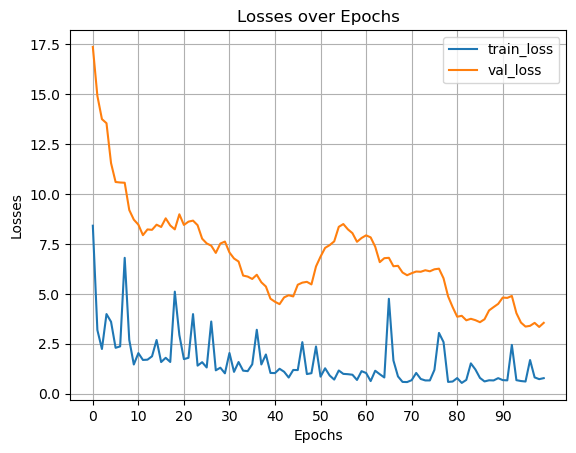

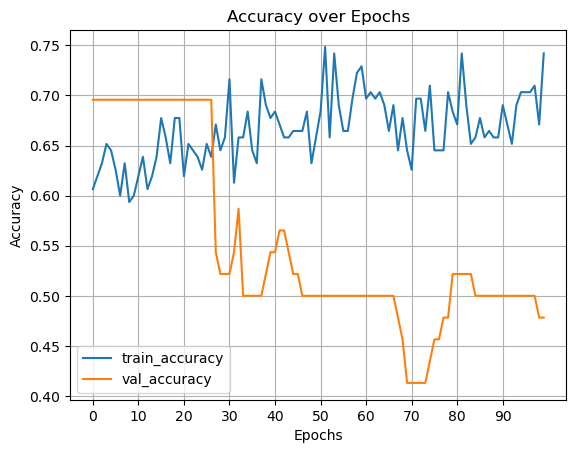

In [32]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(epochs), train_metric)
    plt.plot(range(epochs), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage for losses
plot_metrics(epochs, train_losses, val_losses, 'loss', 'Losses', 'Losses over Epochs')

# Example usage for accuracies
plot_metrics(epochs, train_accuracies, val_accuracies, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

In [33]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [34]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Category: {label_to_category[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_category[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_category[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

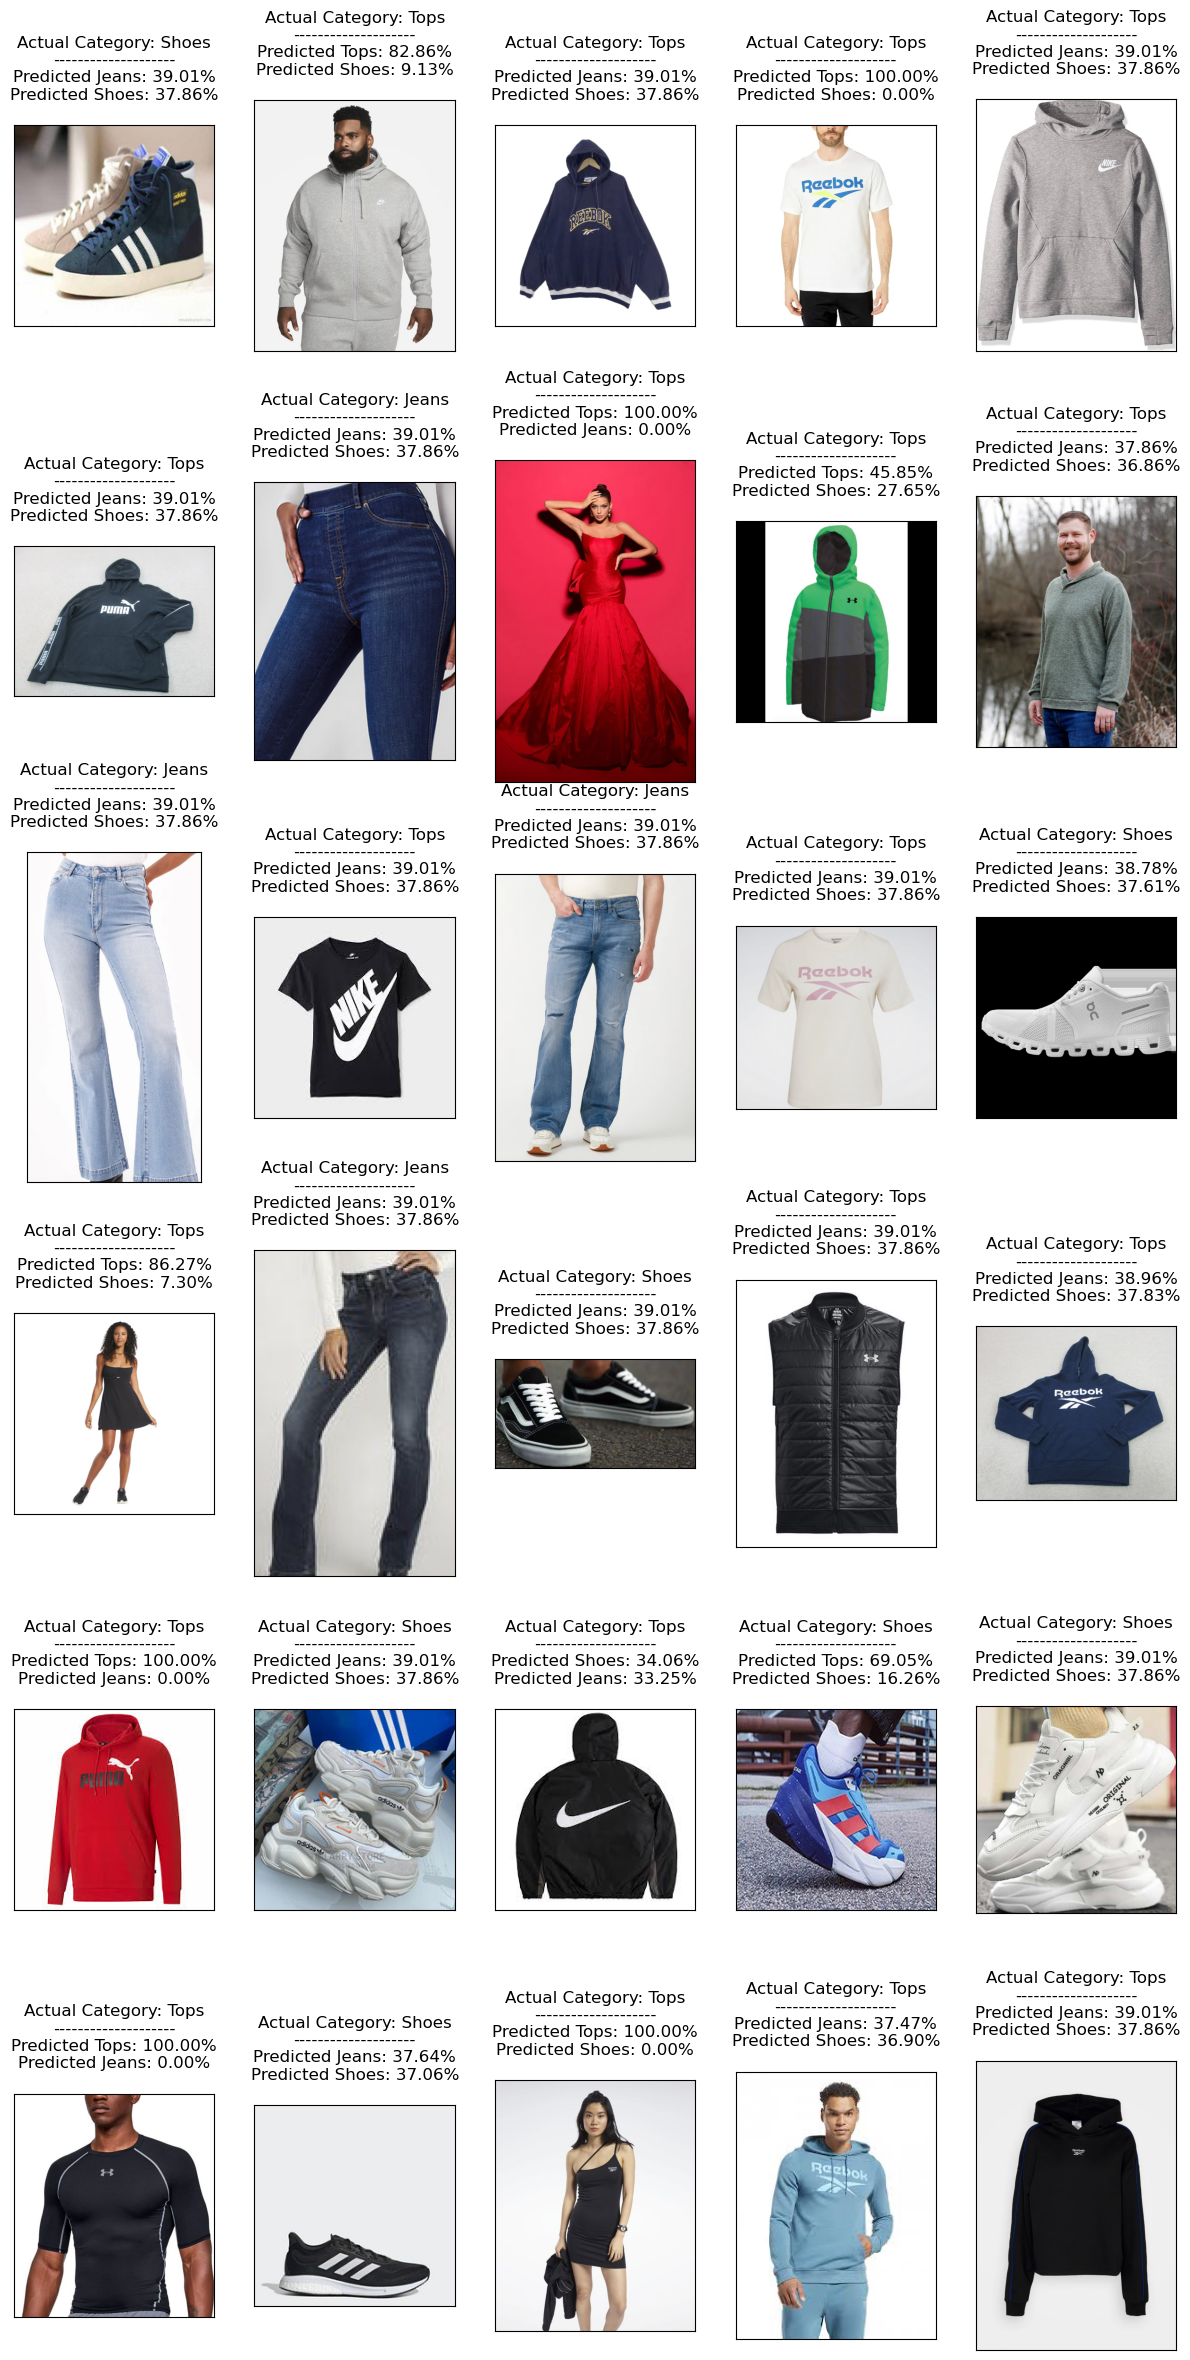

In [35]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)